In [30]:
import xarray as xr
#import cdsapi
import os
import matplotlib.pyplot as plt
import numpy as np
import iris
import xesmf as xe 
import pandas as pd
from time import time
import scipy 

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen/'

# Code to test rotation script

In [2]:
v_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_v_component_of_wind.nc')
u_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_u_component_of_wind.nc')
v_sps_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_v_component_of_wind_SPS.nc')
u_sps_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_u_component_of_wind_SPS.nc')

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

u_test, v_test = u_ds.u10.isel(expver=0, time=0), v_ds.v10.isel(expver=0, time=0)
u_test, v_test = u_test.sel(latitude=slice(-45,-90)), v_test.sel(latitude=slice(-45,-90))

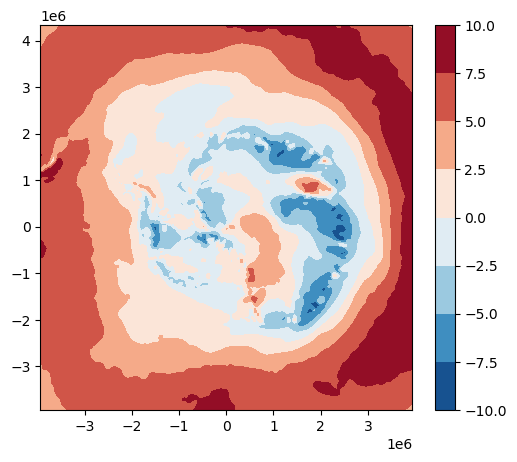

In [12]:

u_sps_plot = u_sps_ds.u10.isel(expver=0, time=0)
plt.figure(figsize=(6,5))
plt.contourf(u_sps_plot.xgrid, u_sps_plot.ygrid, u_sps_plot, cmap='RdBu_r')
plt.colorbar()

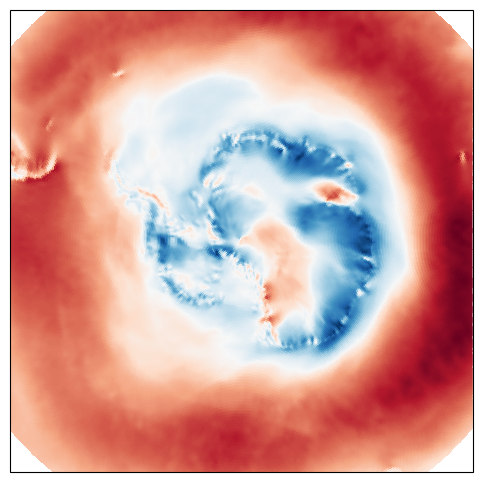

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.pcolormesh(u_test.longitude, u_test.latitude, u_test, transform=ccrs.PlateCarree(), cmap='RdBu_r')

In [2]:
era5_sic = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/sea_ice_cover_SPS.nc').siconc.isel(time=12, expver=0)
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_sh_197901_n07_v04r00.nc').cdr_seaice_conc_monthly.isel(tdim=0)

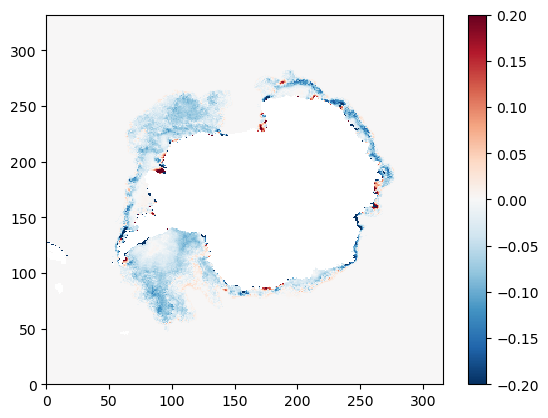

In [13]:
plt.pcolormesh(era5_sic.values - nsidc_sic.values, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
plt.colorbar()

### Inputs/outputs

In [31]:
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc')

# For some reason, there are two months containing missing data (all the sea ice extent is NaN)
# For now, just remove those times from consideration 
nsidc_sic = nsidc_sic.sel(time=nsidc_sic.time[np.isnan(nsidc_sic.siconc).sum(dim=('x', 'y')) == 0])

land_mask = np.logical_or(nsidc_sic.siconc.isel(time=0) == 2.53, nsidc_sic.siconc.isel(time=0) == 2.54)
all_zeros_mask = np.sum(nsidc_sic.siconc == 0, axis=0) == len(nsidc_sic.time)
land_and_open_ocean_mask = ~np.logical_or(land_mask.values, all_zeros_mask.values)

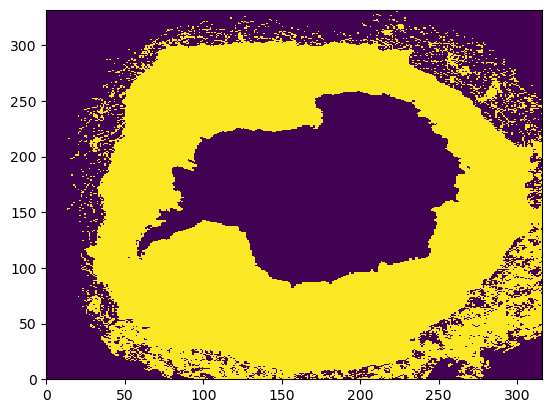

In [32]:
plt.pcolormesh(land_and_open_ocean_mask)

Below is an example of this missing data. It occurs for 1987 December and 1988 January

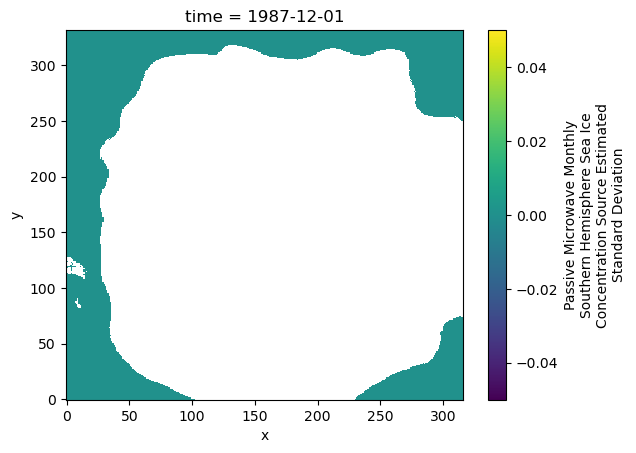

In [100]:
nsidc_sic.stdev_of_cdr_seaice_conc_monthly.sel(time=pd.to_datetime('1987-12')).plot()

In [6]:
target_month = pd.to_datetime('2020-12')
initial_year = pd.to_datetime('1987-11')

# subset 
subset_target_months = nsidc_sic.siconc.sel(time=nsidc_sic.time.dt.month == target_month.month)
subset_target_months = subset_target_months.sel(time=slice(initial_year, target_month - pd.DateOffset(years=1)))

def linear_regress_array(x_arr, y_arr, axis=0, mask=None):
    num_dimensions = y_arr.ndim
    
    if axis >= num_dimensions or axis < 0:
        raise ValueError(f"Axis {axis} is out of bounds for array of dimension {num_dimensions}")
    
    if x_arr.ndim == 1:
        if len(x_arr) != y_arr.shape[axis]:
            raise ValueError(f"Length of x_arr must match the size of y_arr along axis {axis}")

    if mask is None:
        mask = np.ones_like(y_arr, dtype=bool)
        
    # Get the shape of the input array and modify it for the output array
    original_shape = list(y_arr.shape)
    modified_shape = original_shape.copy()
    modified_shape[axis] = 2
    result_array = np.empty(modified_shape)
    
    # Iterate over all slices along the specified axis and perform linear regression
    start_time = time()
    it = np.nditer(np.zeros(original_shape), flags=['multi_index'])
    while not it.finished:
        idx = it.multi_index

        y_slice_index = list(idx)
        y_slice_index[axis] = slice(None)

        mask_index = idx[:axis] + idx[axis+1:]
        mask_slice = mask[mask_index]
        if np.any(mask_slice):
            # Select the current slices of x_arr and y_arr
            if x_arr.ndim == 1:
                x_slice = x_arr
            else:
                x_slice = x_arr[tuple(y_slice_index)]
            
            y_slice = y_arr[tuple(y_slice_index)]
            A = np.vstack([x_slice, np.ones_like(x_slice)]).T
            slope, intercept = np.linalg.lstsq(A, y_slice, rcond=None)[0]
        else:
            slope, intercept = 0.0, 0.0
        
        # Store the results in the result_array
        result_array[tuple(y_slice_index)] = [slope, intercept]
        
        it.iternext()

    end_time = time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")

    return result_array



test_reg_result = linear_regress_array(subset_target_months.time.dt.year.values, subset_target_months.values, mask=land_and_open_ocean_mask)

Elapsed time: 70.1704 seconds


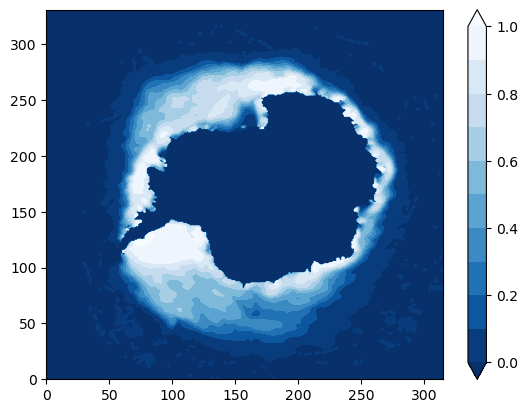

In [18]:
prediction = test_reg_result[0] * target_month.year + test_reg_result[1]
plt.contourf(prediction, levels=np.arange(0, 1.1, 0.1), cmap='Blues_r', extend='both')
plt.colorbar()

In [29]:
os.path.join(DATA_DIRECTORY, "test.nc")

'/scratch/groups/earlew/yuchen/test.nc'

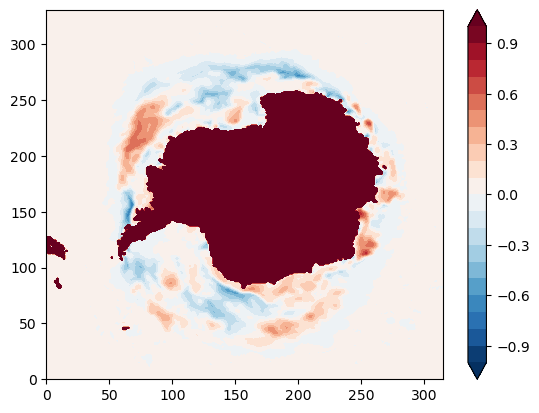

In [22]:
truth = nsidc_sic.siconc.sel(time=pd.to_datetime('2020-12'))
plt.contourf(truth - prediction, levels=np.arange(-1, 1.1, 0.1), cmap='RdBu_r', extend='both')
plt.colorbar()

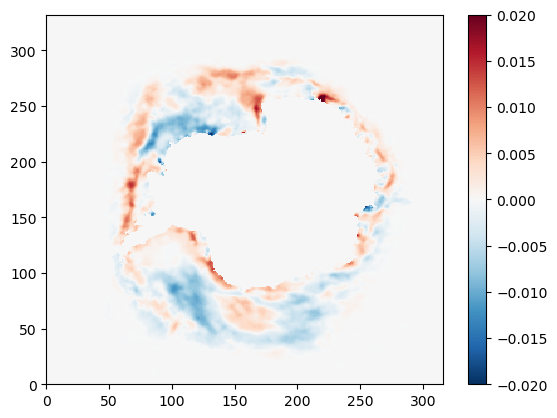

In [8]:
plt.pcolormesh(test_reg_result[0], vmin=-0.02, vmax=0.02, cmap='RdBu_r')
plt.colorbar()